## Figure B1: Hilbert Space Gaussian process (HSGP) approximation
This notebook can be used to: 

In [1]:
%load_ext autoreload
%autoreload 2


import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from matplotlib import rcParams

import stratmc

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Avenir"]
rcParams.update({"text.usetex": False})

import warnings

from scipy.ndimage import gaussian_filter as gaussian
from scipy.stats import gaussian_kde

warnings.simplefilter(action="ignore", category=FutureWarning)

## Load synthetic data

## Synthetic d13C signal and data
Use the same d13C signal and observations as in Fig. 8

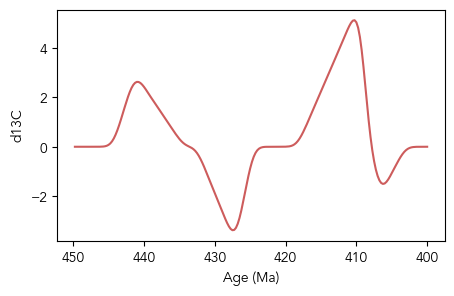

In [2]:
age_vector = np.arange(400, 450, 0.25)
amplitude = [3, -4, 6, -2]
d13c_signal = stratmc.synthetics.make_excursion(
    age_vector,
    amplitude,
    excursion_duration=[10, 8, 10, 5],
    rising_time=[0.3, 0.7, 0.9, 0.3],
    smooth=True,
    smoothing_factor=2,
    rate_offset=True,
    seed=7,
)

d13c_signal = gaussian(np.flip(d13c_signal), 3)

signal_dict = {}
signal_dict["d13c"] = d13c_signal

fig = plt.figure(figsize=(5, 3))
ax = fig.gca()

ax.plot(age_vector, d13c_signal, color="indianred")

ax.invert_xaxis()
ax.set_xlabel("Age (Ma)")
ax.set_ylabel("d13C");

In [8]:
sample_df = stratmc.data.load_object(
    "data/Fig8_synthetic_sample_df_multiproxy_modified"
)
ages_df = stratmc.data.load_object("data/Fig8_synthetic_ages_df_multiproxy_modified")

sections = np.unique(sample_df["section"].values)

## HSGP approximation: Trial 1 
First, we try the HSGP approximation with $m$ and $c$ parameters optimized for the full range of the lengthscale prior. Later, we'll narrow down the likely range of lengthscales to reduce $m$ and $c$, which will speed up sampling time.

### Configure the HSGP approximation
Here, we build an inference model and sample the prior in order to estimate the full range of possible lengthscales. We'll then use this range to estimate optimal values for the $m$ and $c$ parameters for the HSGP approximation using `pymc.gp.hsgp_approx.approx_hsgp_hyperparams`. 

Note that the recommended values might vary slightly for different sets of prior draws. 

In [4]:
# Build unapproximated GP model
proxies = ["d13c"]

model, gp = stratmc.model.build_model(
    sample_df,
    ages_df,
    proxies=proxies,
    ls_dist="Wald",
    ls_min=3,  # minimum RBF kernel lengthscale
    ls_mu=10,  # mean of Wald distribution used as RBF kernel lengthscale prior
    ls_lambda=25,  # lambda of Wald distribution used as RBF kernel lengthscale prior
    offset_type="section",  # per-section offset with default prior
    noise_type="section",  # per-section noise with default prior
)

In [5]:
# Sample the model prior
ls_names = []
for proxy in proxies:
    ls_names.append("gp_ls_" + proxy)

with model:
    prior = pm.sample_prior_predictive(draws=100000, var_names=ls_names)

Sampling: [gp_ls_unshifted_d13c]


In [6]:
# using the prior draws to estimate the range of possible lengthscales, then calculate optimal HSGP parameters
proxy = "d13c"

ls_min = np.min(az.extract(prior.prior)["gp_ls_" + proxy].values.ravel())
ls_max = np.max(az.extract(prior.prior)["gp_ls_" + proxy].values.ravel())

m, c = pm.gp.hsgp_approx.approx_hsgp_hyperparams(
    x_range=[np.min(ages_df["age"].values), np.max(ages_df["age"].values)],
    lengthscale_range=[ls_min, ls_max],
    cov_func="expquad",
)

print("Recommended smallest number of basis vectors (m) for", str(proxy), ": ", m)
print("Recommended smallest scaling factor (c) for", str(proxy), ": ", np.round(c, 1))

hsgp_m = m
hsgp_c = c

del prior

Recommended smallest number of basis vectors (m) for d13c :  137
Recommended smallest scaling factor (c) for d13c :  12.3


### Build model using the HSGP approximation with the recommended $m$ and $c$ parameters

To load the inference results used to produce Fig. B1b, skip to [Load the inference results (HSGP, trial 1)](#Load-the-inference-results-(HSGP,-trial-1)). 

In [7]:
# Build unapproximated GP model
proxies = ["d13c"]

model, gp = stratmc.model.build_model(
    sample_df,
    ages_df,
    proxies=proxies,
    approximate=True,
    hsgp_m=137,
    hsgp_c=12.3,
    ls_dist="Wald",
    ls_min=3,  # minimum RBF kernel lengthscale
    ls_mu=10,  # mean of Wald distribution used as RBF kernel lengthscale prior
    ls_lambda=25,  # lambda of Wald distribution used as RBF kernel lengthscale prior
    offset_type="section",  # per-section offset with default prior
    noise_type="section",  # per-section noise with default prior
)

Using HSGP approximation for  d13c


In [19]:
age_min = 400
age_max = 450

predict_ages = np.arange(age_min, age_max + 0.5, 0.5)[:, None]

chains = 100
draws = 1000
tune = 1000
target_accept = 0.9

extension = "FigB1_hsgp_m137_c12.3"

full_trace_hggp_1 = stratmc.inference.get_trace(
    model,
    gp,
    predict_ages,
    sample_df,
    ages_df,
    approximate=True,
    proxies=proxies,
    name=extension,
    chains=100,
    target_accept=0.9,
)

### Load the inference results (HSGP, trial 1)

In [6]:
full_trace_hsgp_1 = stratmc.data.load_trace("traces/FigB1_hsgp_m137_c12.3")

### Plot the results
The results look good, but we didn't get a huge speed-up compared to the unapproximated GP. 

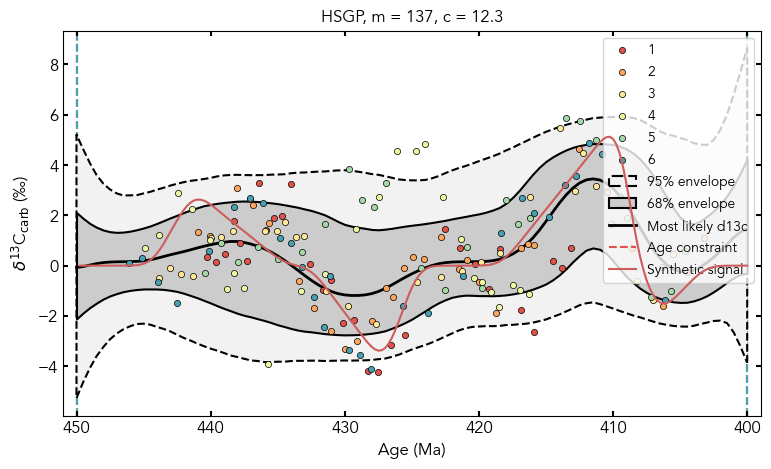

In [7]:
fig = stratmc.plotting.proxy_inference(
    sample_df,
    ages_df,
    full_trace_hsgp_1,
    sections=sections,
    orientation="horizontal",
    plot_constraints=True,
    plot_data=True,
    section_legend=True,
)

ax = fig.gca()
ax.plot(age_vector, d13c_signal, color="indianred", label="Synthetic signal", zorder=10)

plt.title("HSGP, m = 137, c = 12.3")

plt.legend()

## HSGP approximation: Trial 2
Now, we're going to use the inference results from the unapproximated GP (the single-proxy d13C inference in Fig. 8) to constrain the range of likely posterior lengthscales. This will allow us to use much smaller values for $m$ and $c$, which will reduce sampling time.


### Load inference from unapproximated GP model 

In [11]:
full_trace_unapprox = stratmc.data.load_trace("traces/Fig8_multiproxy_d13c")

/Users/staceyedmonsond/opt/anaconda3/envs/bayestrat-dev-m1-pymc516-accelerate/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: X_new group is not defined in the InferenceData scheme
  warnings.warn(


### Configure the HSGP approximation
Use the posterior distribution for the RBF kernel lengthscale from the unapproximated model to estimate optimal values for the $m$ and $c$ parameters for the HSGP approximation using `pymc.gp.hsgp_approx.approx_hsgp_hyperparams`. 

In [12]:
proxy = "d13c"

ls_min = np.min(
    az.extract(full_trace_unapprox.posterior)["gp_ls_" + proxy].values.ravel()
)
ls_max = np.max(
    az.extract(full_trace_unapprox.posterior)["gp_ls_" + proxy].values.ravel()
)

m_2, c_2 = pm.gp.hsgp_approx.approx_hsgp_hyperparams(
    x_range=[np.min(ages_df["age"].values), np.max(ages_df["age"].values)],
    lengthscale_range=[ls_min, ls_max],
    cov_func="expquad",
)

print("Recommended smallest number of basis vectors (m) for", str(proxy), ": ", m_2)
print("Recommended smallest scaling factor (c) for", str(proxy), ": ", np.round(c_2, 1))

hsgp_m = m_2
hsgp_c = c_2

Recommended smallest number of basis vectors (m) for d13c :  15
Recommended smallest scaling factor (c) for d13c :  1.3


### Build model using the HSGP approximation with the recommended $m$ and $c$ parameters
These $m$ and $c$ values should result in much faster sampling -- recall the $\mathcal{O}(mn + m)$ scaling of the HSGP approximation.  

To load the inference results used to produce Fig. B1c, skip to [Load the inference results (HSGP, trial 2)](#Load-the-inference-results-(HSGP,-trial-2)). 

In [13]:
# Build unapproximated GP model
proxies = ["d13c"]

model, gp = stratmc.model.build_model(
    sample_df,
    ages_df,
    proxies=proxies,
    approximate=True,
    hsgp_m=15,
    hsgp_c=1.3,
    ls_dist="Wald",
    ls_min=3,  # minimum RBF kernel lengthscale
    ls_mu=10,  # mean of Wald distribution used as RBF kernel lengthscale prior
    ls_lambda=25,  # lambda of Wald distribution used as RBF kernel lengthscale prior
    offset_type="section",  # per-section offset with default prior
    noise_type="section",  # per-section noise with default prior
)

Using HSGP approximation for  d13c


In [ ]:
age_min = 400
age_max = 450

predict_ages = np.arange(age_min, age_max + 0.5, 0.5)[:, None]

chains = 100
draws = 1000
tune = 1000
target_accept = 0.9

extension = "FigB1_hsgp_m15_c1.3"

full_trace_hggp_2 = stratmc.inference.get_trace(
    model,
    gp,
    predict_ages,
    sample_df,
    ages_df,
    approximate=True,
    proxies=proxies,
    name=extension,
    chains=100,
    target_accept=0.9,
)

### Load the inference results (HSGP, trial 2)

In [14]:
full_trace_hsgp_2 = stratmc.data.load_trace("traces/FigB1_hsgp_m15_c1.3")

/Users/staceyedmonsond/opt/anaconda3/envs/bayestrat-dev-m1-pymc516-accelerate/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: X_new group is not defined in the InferenceData scheme
  warnings.warn(


### Plot the results
The results look identical to the model with $m = 137$ and $c = 12.3$, and sampling was much faster!

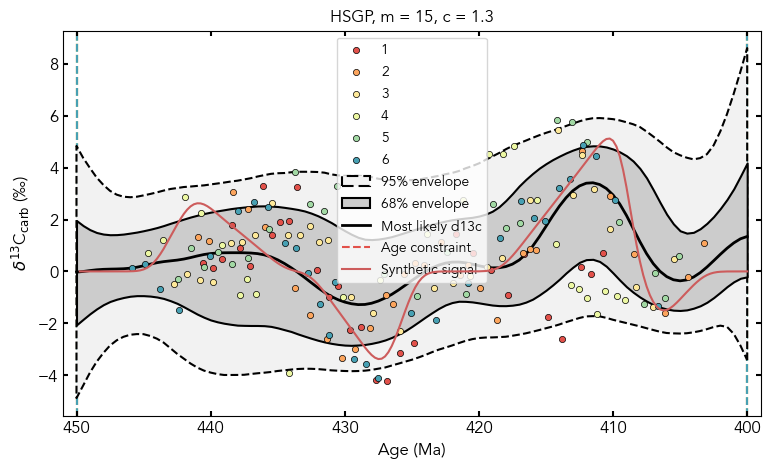

In [15]:
fig = stratmc.plotting.proxy_inference(
    sample_df,
    ages_df,
    full_trace_hsgp_2,
    sections=sections,
    orientation="horizontal",
    plot_constraints=True,
    plot_data=True,
    section_legend=True,
)

ax = fig.gca()
ax.plot(age_vector, d13c_signal, color="indianred", label="Synthetic signal", zorder=10)

plt.title("HSGP, m = 15, c = 1.3")

plt.legend()

## Compare results of the HSGP approximations with the unapproximated GP (Fig. B1) 
Pulling it all together, we can compare the proxy signal inference from the unappromated GP model with our two HSGP models. The proxy signal inferences for the unapproximated GP and HSGP models are practically indistinguishable. 

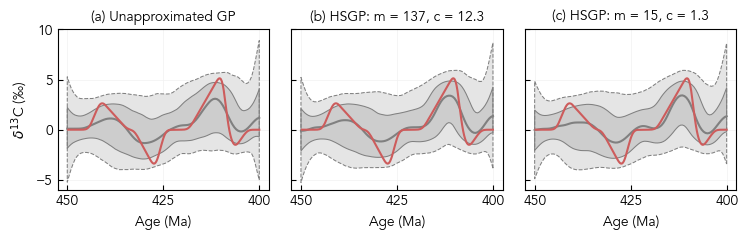

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(7.6, 2.5), sharex=True, sharey=True)

fs = 10

ax[0].set_title("(a) Unapproximated GP", fontsize=fs)
ax[1].set_title("(b) HSGP: m = {}, c = {}".format(m, round(c, 1)), fontsize=fs)
ax[2].set_title("(c) HSGP: m = {}, c = {}".format(m_2, round(c_2, 1)), fontsize=fs)

# latent GP posterior
ages = full_trace_unapprox.X_new.X_new.values
proxy_pred = az.extract(full_trace_unapprox.posterior_predictive)[
    "f_pred_" + "d13c"
].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax[0].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="white",
    linestyle="--",
    edgecolor="none",
    alpha=1,
    lw=0,
    zorder=1,
)

ax[0].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="black",
    linestyle="--",
    edgecolor="none",
    alpha=0.1,
    lw=0,
    zorder=2,
)

ax[0].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="95% envelope",
    linestyle="--",
    edgecolor="gray",
    alpha=1,
    lw=0.75,
    zorder=3,
)

hi = np.percentile(proxy_pred, 100 - 16, axis=1).flatten()

lo = np.percentile(proxy_pred, 16, axis=1).flatten()

ax[0].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="black",
    edgecolor="none",
    alpha=0.1,
    lw=0,
    zorder=4,
)

ax[0].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="68% envelope",
    edgecolor="gray",
    alpha=1,
    lw=0.75,
    zorder=5,
)

dy = np.linspace(np.min(proxy_pred.ravel()), np.max(proxy_pred.ravel()), 200)
max_like = np.zeros(ages.size)
for i in np.arange(ages.size):
    time_slice = proxy_pred[i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method=1)(dy))]


max_like = gaussian(max_like, 2)
ax[0].plot(
    ages.ravel(),
    max_like,
    color="gray",
    linestyle="solid",
    lw=1.5,
    zorder=6,
    label="Most likely $\delta^{13}$C",
)

ax[0].plot(age_vector, d13c_signal, color="indianred", label="True Signal", zorder=10)

# latent GP posterior
ages = full_trace_hsgp_1.X_new.X_new.values
proxy_pred = az.extract(full_trace_hsgp_1.posterior_predictive)[
    "f_pred_" + "d13c"
].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax[1].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="white",
    linestyle="--",
    edgecolor="none",
    alpha=1,
    lw=0,
    zorder=1,
)

ax[1].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="black",
    linestyle="--",
    edgecolor="none",
    alpha=0.1,
    lw=0,
    zorder=2,
)

ax[1].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="95% envelope",
    linestyle="--",
    edgecolor="gray",
    alpha=1,
    lw=0.75,
    zorder=3,
)

hi = np.percentile(proxy_pred, 100 - 16, axis=1).flatten()

lo = np.percentile(proxy_pred, 16, axis=1).flatten()

ax[1].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="black",
    edgecolor="none",
    alpha=0.1,
    lw=0,  # 1.5
    zorder=4,
)

ax[1].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="68% envelope",
    edgecolor="gray",
    alpha=1,
    lw=0.75,
    zorder=5,
)

dy = np.linspace(np.min(proxy_pred.ravel()), np.max(proxy_pred.ravel()), 200)
max_like = np.zeros(ages.size)
for i in np.arange(ages.size):
    time_slice = proxy_pred[i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method=1)(dy))]


max_like = gaussian(max_like, 2)
ax[1].plot(
    ages.ravel(),
    max_like,
    color="gray",
    linestyle="solid",
    lw=1.5,
    zorder=6,
    label="Most likely $\delta^{13}$C",
)

ax[1].plot(age_vector, d13c_signal, color="indianred", label="True Signal", zorder=10)

# latent GP posterior
ages = full_trace_hsgp_2.X_new.X_new.values
proxy_pred = az.extract(full_trace_hsgp_2.posterior_predictive)[
    "f_pred_" + "d13c"
].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax[2].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="white",
    linestyle="--",
    edgecolor="none",
    alpha=1,
    lw=0,
    zorder=1,
)

ax[2].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="black",
    linestyle="--",
    edgecolor="none",
    alpha=0.1,
    lw=0,
    zorder=2,
)

ax[2].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="95% envelope",
    linestyle="--",
    edgecolor="gray",
    alpha=1,
    lw=0.75,
    zorder=3,
)

hi = np.percentile(proxy_pred, 100 - 16, axis=1).flatten()

lo = np.percentile(proxy_pred, 16, axis=1).flatten()

ax[2].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="black",
    edgecolor="none",
    alpha=0.1,
    lw=0,
    zorder=4,
)

ax[2].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="68% envelope",
    edgecolor="gray",
    alpha=1,
    lw=0.75,
    zorder=5,
)

dy = np.linspace(np.min(proxy_pred.ravel()), np.max(proxy_pred.ravel()), 200)
max_like = np.zeros(ages.size)
for i in np.arange(ages.size):
    time_slice = proxy_pred[i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method=1)(dy))]

max_like = gaussian(max_like, 2)
ax[2].plot(
    ages.ravel(),
    max_like,
    color="gray",
    linestyle="solid",
    lw=1.5,
    zorder=6,
    label="Most likely $\delta^{13}$C",
)

ax[2].plot(age_vector, d13c_signal, color="indianred", label="True Signal", zorder=10)


for i in [0, 1, 2]:
    ax[i].set_axisbelow(True)
    ax[i].grid(color=(0.95, 0.95, 0.95), linewidth=0.5, linestyle="solid", zorder=-1)
    ax[i].tick_params(labelsize=fs)

for i in [0, 1, 2]:
    ax[i].tick_params(direction="in", labelsize=fs)
    ax[i].set_xlabel("Age (Ma)", fontsize=fs)

ax[0].set_ylabel("$\delta^{13}$C (‰)", fontsize=fs)

ax[0].invert_xaxis()

ax[0].set_xticks([450, 425, 400])
ax[0].set_xlim([np.max(ages) + 2.5, np.min(ages) - 2.5])

ax[0].set_yticks([-5, 0, 5, 10])

fig.tight_layout()